In [1]:
import pandas as pd
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.chains import TransformChain
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from langchain.load import dumps, loads
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_core.runnables import RunnablePassthrough

from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = './Dataset/instagram.csv'
K_RETRIEVER_VALUE = 10

openai_embedding = OpenAIEmbeddings()

llm = ChatOpenAI(temperature=0) 

query = "What are the specific features or aspects that users appreciate the most in our application?"
# # query = "What are the primary reasons users express dissatisfaction with Instagram?"
# # query = "Can you identify emerging trends or patterns in recent user reviews that may impact our product strategy?

### Store to Vector DB

In [3]:
df = pd.read_csv(DATASET_PATH)[:10000]
dict_data = df.to_dict(orient="records")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  10000 non-null  object
 1   rating              10000 non-null  int64 
 2   review_date         10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [4]:
df.head(3)
print(df['rating'].value_counts())

rating
1    5378
2    1769
3    1379
4     811
5     663
Name: count, dtype: int64


In [5]:
display(df.isna().sum())
df.duplicated().sum()

review_description    0
rating                0
review_date           0
dtype: int64

0

In [6]:
display(df.head(3))

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",2,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,5,2023-07-25 03:24:58


Highest Token Count : 199


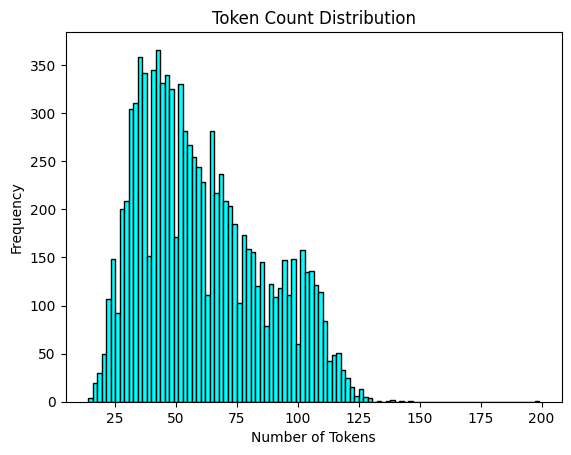

In [7]:
data = df['review_description']
token_count = []
encoding = tiktoken.get_encoding('cl100k_base')
max_token = 0
for i in data:
    num_tokens = len(encoding.encode(i))
    if max_token < num_tokens:
        max_token = num_tokens
    token_count.append(num_tokens)
    # print(num_tokens)
print(f"Highest Token Count : {max_token}")
plt.hist(token_count, bins=100, color='cyan', edgecolor='black')
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [8]:

documents = [
    Document(
        page_content=item["review_description"],
        metadata={"rating": item["rating"], "review_date": item["review_date"]}
    )
    for item in dict_data
]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=120,  
    chunk_overlap=10  
)

print("Splitting...")
splits = text_splitter.split_documents(documents)
print("Storing...")
vector_store = Chroma.from_documents(documents=documents, embedding=openai_embedding)
retriever = vector_store.as_retriever(search_kwargs={"k": K_RETRIEVER_VALUE})


Splitting...
Storing...


In [9]:
print(f"Question : {query}")

results = retriever.get_relevant_documents(query)
for result in results:
    print(f"Review Chunk: {result.page_content}")
    print(f"Metadata: {result.metadata}")
    print()
    # break

Question : What are the specific features or aspects that users appreciate the most in our application?


C:\Users\Win10\AppData\Local\Temp\ipykernel_35928\2263227541.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(query)


Review Chunk: Being a recent new user, i am delighted to use this app. Still getting acquainted and understanding it's features. It takes time to fall in love!
Metadata: {'rating': 4, 'review_date': '2023-06-18 02:01:00'}

Review Chunk: This app is very good to spend time by watching reels, chatting our freinds connecting with many people online and for many other things. I just have a problem that some features of chat aren't available in my device like replying, Themes and other things.. I just want the developers to fix this problem I would be thankful to them. My account name is techno_angshuman.
Metadata: {'rating': 4, 'review_date': '2023-06-04 13:23:30'}

Review Chunk: This app is very good and has many features But the flaw i feel is that some privacy options in chats and online system is very dull it dosent work propely. Moreover there are not precise options for every thing. Like there should be when to show online status and exact time Beside these there are certain other th

### Query Translation

In [10]:
template = """You are an AI language model assistant. Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database. By generating multiple perspectives on the user question, your goal is to help the user overcome some of the limitations of the distance-based similarity search. Please focus on the clarity of the question and add more details to it. Provide these alternative questions separated by newlines. Original question: {query}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

print(generate_queries.invoke({"query":query}))

['1. Can you identify the key features or aspects of our application that users find most appealing?', '2. What specific elements of our application do users value the most?', '3. Which features or aspects of our application receive the highest praise from users?', '4. What are the standout features or aspects of our application that users particularly enjoy?', '5. Can you pinpoint the specific aspects of our application that users find most favorable?']


### Get Docs from Vector DB

In [13]:
def get_only_unique(documents):
    flattened = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened))
    return [loads(doc) for doc in unique_docs]

def process_multiple_queries(inputs):
    # print(type(inputs))
    # print(inputs)
    queries = inputs["query"]
    retrieval_results = [retriever.get_relevant_documents(query) for query in queries]
    # print(retrieval_results)
    unique_docs = get_only_unique(retrieval_results)
    
    return {"documents": unique_docs}

### Retrieval

In [15]:
retrieval_chain = TransformChain(
    input_variables=["query"],  
    output_variables=["documents"],  
    transform=process_multiple_queries 
)
queries = generate_queries.invoke({"query":query})
docs = retrieval_chain.invoke({"query": queries})
print(docs)


{'query': ['1. Can you identify the key features or aspects of our application that users find most appealing?', '2. What specific elements of our application do users value the most?', '3. Which features or aspects of our application receive the highest praise from users?', '4. What are the standout features or aspects of our application that users particularly enjoy?', '5. Can you pinpoint the specific aspects of our application that users find most favorable?'], 'documents': [Document(metadata={'rating': 5, 'review_date': '2023-06-17 01:09:05'}, page_content="Great app, my rating used to be 5/5, but the inability to change settings within the app has become frustrating as it relies on your phone's settings unlike literally every other app ever."), Document(metadata={'rating': 5, 'review_date': '2023-06-23 17:54:12'}, page_content="Smooth & easy to navigate. You can always discover exciting, interesting, and current events. Oftentimes, this app keeps abreast of events I'm otherwise n

C:\Users\Win10\AppData\Local\Temp\ipykernel_35928\2003444613.py:4: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


In [16]:
test = docs['documents']
print(len(test))
for i in test:
    print(i)

28
page_content='Great app, my rating used to be 5/5, but the inability to change settings within the app has become frustrating as it relies on your phone's settings unlike literally every other app ever.' metadata={'rating': 5, 'review_date': '2023-06-17 01:09:05'}
page_content='Smooth & easy to navigate. You can always discover exciting, interesting, and current events. Oftentimes, this app keeps abreast of events I'm otherwise not aware of.' metadata={'rating': 5, 'review_date': '2023-06-23 17:54:12'}
page_content='It's a pretty nice app to share your thoughts with other people and connect with like minded ones. but one thing that I will request instagram and think that it can make its usage even better is a post privacy feature as facebook tbh I think this is the only reason why people have to create second account they won't need to if you introduce this to them and it will gave your users a better user experience' metadata={'rating': 2, 'review_date': '2023-07-18 08:23:11'}
page

### Generation

In [17]:
template = """You are an AI assistant for question-answering tasks. Use the following pieces of retrieved context and information to answer the question. If you don't know the answer, say that you don't know. If the data is not relevant to the question, don't use the data. Make sure to give a detailed answer. Context: {context} Question: {query}"""
prompt = ChatPromptTemplate.from_template(template)

generation_chain = (
    {"context": RunnablePassthrough(), "query": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# print(generation_chain)
generation_chain.invoke({"query": query, "context":docs['documents']})


"Based on the reviews provided, users appreciate several specific features and aspects of the Instagram application:\n\n1. User-Friendly Interface: Users find the interface of Instagram to be intuitive, easy to navigate, and visually appealing. They appreciate the seamless stream of posts on the home feed, ensuring they stay updated on content from accounts they follow.\n\n2. Content Discovery: Users enjoy the Explore page, which intelligently curates content based on their interests and preferences. This feature helps users discover new and engaging content on the platform.\n\n3. Creative Tools: Users appreciate the diverse range of filters and editing tools available on Instagram, which enhance their creativity when sharing photos and videos. Features like Stories and Reels also contribute to the creative expression of users.\n\n4. Connectivity and Social Interaction: Users value the ability to connect with friends, family, and like-minded individuals on Instagram. They enjoy sharing